## ECE495 In-class Exercise 2: Spiking Neural Networks using NengoDL

This ICE uses NengoDL and TensorFlow's Keras to:

1. Load a prebuilt dataset.
2. Build a simple *spiking* neural network that classifies images. The neural network will utilize the equivalent layers as those from ICE1! Be sure to draw the parallels between the two networks as you work through this.
3. Train the spiking neural network.
4. Evaluate the accuracy of the spiking network.

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
  
If you are using your virtual environment, the next section should run without issue. If you are not in your virtual environment (or your environment did not install properly), you'll see a lot of red.
  
Import Nengo, NengoDL, TensorFlow and other supporting libraries into your program to get started:

In [1]:
from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

## Load a dataset

Load and prepare the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The pixel values of the images range from 0 through 255. Recall in ICE1, we had to normalize the values. For this spiking neural network, we do not have to do that. _Ensure you understand why we don't have to normalize the input values._

We are going to get into how data is encoded using Nengo neuron ensembles in the next few lectures. Until then, the main point you need to understand is that we cannot simply send an image into an SNN. Recall that an SNN uses spikes (only 1's) and an image is made up of pixel values ranging from 0 to 255 (integers) for MNIST. So, how might you encode pixels via spikes? 

For this network, rate encoding is used (Nengo will do this for you - don't panic). This means that if the pixel value is higher, you'll see more spikes over a duration of time. If your pixel value is 0, how many spikes do you think you'll see? Hopefully your intuition says 0 spikes! If you are curious, you can read more about this encoding in [the response](https://forum.nengo.ai/t/how-are-spikes-generated-within-nengodl/2130) to this forum question.

Why am I telling you all of this? Nengo ensembles (which will be used to rate encode your MNIST images) can only accept vector inputs (i.e. 1xN arrays). MNIST data is made up of 70,000 28x28 matrices - remember, you can click the `Variables` tab at the top to verify this info. Therefore to encode the data, we must convert all of our training and testing data to arrays. Note: this is the exact same thing the flatten layer did in our Neural Network from ICE1. As it turns out, the flatten layer does not have any trainable parameters (no weights or biases)! 

<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

This is the first section you are required to edit!
1. Grab the dataset from tf.keras in the exact same way you did for ICE1. Replace `???` with the correct command on the first line.
2. No need to normalize the data this time since Nengo will rate encode it for us (meaning the rate encoding would result in the same spike rates - consider why this might be). Instead, flatten each of your images by converting your matrices of training data from (60000,28,28) to (60000,784) and test data from (10000,28,28) to (10000,784). The [`reshape` command](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) will be helpful to you in flattening your images. If you'd like to avoid hardcoding values (a practice that will serve you well in the second half of this course), you might also take a look at the [`shape` command](https://numpy.org/doc/stable/reference/generated/numpy.shape.html). Replace the `???` with the correct commands. Check your Variables tab to ensure you now have the correct matrix sizes for your training and test data.

</div>

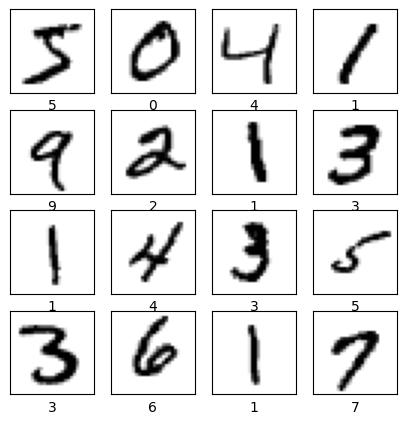

In [8]:
#Load your data
(train_images, train_labels), (test_images, test_labels) = ???

#Take a look at your data just to be sure it loaded as expected
plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

# Flatten your Images
train_images = ???
test_images = ???

## Build a machine learning model

Before we dive in, I want to note that there are a few ways to go from a DNN to an SNN.
1. You can completely train a DNN in Keras, then [build a wrapper](https://www.nengo.ai/nengo-dl/examples/tensorflow-models.html) to integrate the model into NengoDL without retraining. In this case, the neurons within the Keras model are still non-spiking. This would be well-suited for a hybrid algorithm, where part is performed outside of neuromorphic computing architectures. Note: the non-spiking part of the hybrid algorithm cannot directly run on neuromorphic hardware.
2. You can completely train a DNN in Keras, then [convert it](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html) into a SNN. We covered this at a high level during Lecture 5, specifically many of the fine-tuning that must be done to get back your original DNN performance. In fact, if you visit the link, the images should look familiar. 
3. You can train an SNN directly, which is what we will do here. This method trains the network with all of the classic DNN training in mind with the ability to map directly to neuromorphic hardware, i.e. you should get decent performance right after training. You may have to fine-tune SNN parameters, but that's comparable to needing to fine-tune DNN parameters. Don't let ICE1 fool you: if you ever train a legit DNN, you'll need to fine-tune it many times to achieve state of the art results. _Yes, there is an example in the NengoDL literature regarding this method that I will not link here. If you find it, you are welcome to use it as a supplemental resource but please recognize that it will be abundantly clear if you copied it. Should you choose to go the copying route, your grade will suffer._

### Set up the layers

For this network, we will build the same model as we did in ICE1. However, you have preprocessed your data (flattened your images) to replace the Flatten layer. That means your model will consist of the following layers, in order:
1. Dense
2. Dropout
3. Dense

Almost all deep learning methods are based on gradient descent, which means that the network being optimized needs to be differentiable. Deep neural networks are usually built using rectified linear or sigmoid neurons, as these are differentiable nonlinearities. However, in neurmorphic modelling we often want to use spiking neurons, which are not differentiable. So the challenge is how to apply deep learning methods to spiking neural networks.

A method for accomplishing this is presented in Hunsberger and Eliasmith (2016). The basic idea is to use a differentiable approximation of the spiking neurons during the training process, and the actual spiking neurons during inference. _NengoDL will perform these transformations automatically_ if the user tries to optimize a model containing a spiking neuron model that has an equivalent, differentiable rate-based implementation. We, as the users, will use these techniques to develop a network to classify handwritten digits (MNIST) in a spiking network.

We will use [TensorNodes](https://www.nengo.ai/nengo-dl/tensor-node.html) to construct the same network we constructed in ICE1 within Nengo. TensorNodes allow us to directly insert TensorFlow code into Nengo - making the parallels with standard deep networks very clear (i.e. the code looks very much the same!). You will need to pay close attention to the section of the TensorNodes page regarding `nengo_dl.Layer` to construct your layers. Notice that each layer is given a name. Also notice that the given name is then passed to the next layer using a second set of parenthesis - this is how layers are connected within NengoDL. 



<style>
    .questioncolor {
        background-color: #906752;
    }
</style>

<div class="questioncolor">

Given the above information, build your model by adding the appropriate layers in place of the three `???` lines. Be sure to view the TensorNode hyperlink - it will be very helpful in calling your layers correctly. Notice that the first layer is named `inp`. Be sure to keep the output layer's name as `out` to ensure our probes used to analyze our results work correctly. Your `tf.keras.layers` should look identical to ICE1 when called within `nengo_dl.Layer`

</div>

In [8]:
with nengo.Network(seed=0) as net:

    # NengoDL default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)
    nengo_dl.configure_settings(stateful=False)

    # This is the input node that will be used to rate encode in input images (i.e. our Flatten layer from ICE1)
    inp = nengo.Node(np.zeros(train_images.shape[1]))

    # First dense layer
    ???

    # Dropout layer
    ???

    # Final dense layer
    out = ???

    # Here we create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

Construct a Simulator for the network

## Compile your model

A lot more goes into compiling your model within NengoDL due to the spiking nature of the network. 

First, NengoDL needs to set up a simulator to run the the `model.compile`, `model.fit`, and `model.evaluate` functions we ran in ICE1 since we are not working directly within TensorFlow.


Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

[Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function. For this model we will use the **Adam optimization**, which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

[Loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction. For this model, we will use the **Sparse Categorical Crossentropy** loss to compute the crossentropy loss between the labels and predictions.

[Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — This is what is used to monitor the training and testing steps. For this model, we will use **accuracy** computed by the fraction of the images that are correctly classified. The accuracy metric calculates how often predictions equal labels.

In [9]:
minibatch_size = 256
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00


c:\Users\Kaitlin.Fair\AppData\Local\anaconda3\envs\py3.10-nengo3.2\lib\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|###           Constructing graph: build stage (5%)              | ETA: 0:00:00
|##############Constructing graph: build stage (68%)             | ETA: 0:00:00
|  #                      Constructing graph                          | 0:00:00
Constructing graph: build stage finished in 0:00:00
Construction finished in 0:00:00


Next we set up our training/testing data. We need to incorporate time into this data, since Nengo models (and spiking neural networks in general) always contain a temporal aspect (think about the neurons in our brain! We don't feed our brain a photo and turn everything else off until we know what we are looking at. Our neurons are constantly taking in data and firing according to their receptive fields).

When training the model we’ll be using a rate-based approximation, so we can run that for a single timestep. But when testing the model we’ll be using the spiking neuron models, so we need to run the model for multiple timesteps in order to collect the spike data over time.



In [10]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 40
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In order to quantify the network’s performance we’ll use a classification accuracy function (the percentage of test images classified correctly). We’re using a custom function here, because we only want to evaluate the output from the network on the final timestep (as we are simulating the network over time).

You may recall that we used Sparse Categorical Crossentropy as our loss function for our Tensorflow network. This is related to the Sparse Categorical Accuracy metric. This is a metric used to evaluate the accuracy of a classification model. Specifically, it computes the accuracy of the predicted labels against the true labels. In the case of sparse categorical accuracy, it is designed for scenarios where the true labels are integers (sparse) and the predictions are probabilities.

In [11]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})

# print(
#    "Accuracy before training:",
#    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
# )

Train the network! For training we’ll use the standard categorical cross entropy loss function, and the Adam optimizer.

This will take about 45 seconds to run. You can mess with the number of epochs, the minibatch size, or the number of time steps to speed things up. *If you do, note what changes in your results.*

In [12]:
# run training
sim.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)
sim.fit(train_images, {out_p: train_labels}, epochs=5)

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--


c:\Users\Kaitlin.Fair\AppData\Local\anaconda3\envs\py3.10-nengo3.2\lib\site-packages\nengo_dl\simulator.py:1892: UserWarning: Number of elements in input data (60000) is not evenly divisible by Simulator.minibatch_size (256); input data will be truncated.
  warnings.warn(


|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##############Constructing graph: build stage (26%)             | ETA: 0:00:00
|##############Constructing graph: build stage (63%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
234/234 [==============================]

Check the classification accuracy again.

This will take about 30-45 seconds to run (not sure why - bonus points if you figure it out). You can check the accuracy for a fraction of the results to speed things up (recall, there are 10,000 test images). *If you do, note the impact on your results.*


In [ ]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(
        test_images[0 : 256 * 3], {out_p_filt: test_labels[0 : 256 * 3]}, verbose=0
    )["loss"],
    # sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

We can see that the spiking neural network is achieving ~95% accuracy, which is what we would expect for MNIST. n_steps could be increased to further improve performance, since we would get a more accurate measure of each spiking neuron’s output.



In [ ]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()